## Montar Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/Picpay'

In [ ]:
import sys
sys.path.append(path)

## Imports

In [ ]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

## Funções

In [ ]:
from functions import calculate_psi, calculate_ks

## Base

In [ ]:
base = pd.read_csv(f'{path}/base_modelo.csv')
base['VAR_32'] = (base['VAR_32']*1000).round(2)
base['VAR_60'] = (base['VAR_60']*1000).round(2)
base

,id,safra,y,VAR_1,VAR_2,VAR_3,VAR_4,VAR_5,VAR_6,VAR_7,...,VAR_69,VAR_70,VAR_71,VAR_72,VAR_73,VAR_74,VAR_75,VAR_76,VAR_77,VAR_78
0,1,201404,0,0.0,0.0,0.0,0.0,124.54,3277.0,51.98,...,156.38,7.52,0.0,151.0,0.0,3.0,477.84,173.06,0.00,3.0
1,2,201407,0,64.0,0.0,2.0,1.0,47.92,2443.0,84.72,...,707.84,NaN,NaN,187.0,NaN,NaN,NaN,184.69,54.00,NaN
2,3,201405,0,99.0,2.0,2.0,2.0,80.38,1824.0,26.63,...,471.86,NaN,NaN,96.0,NaN,NaN,NaN,732.00,121.98,NaN
3,4,201412,0,0.0,0.0,0.0,0.0,10.58,3796.0,NaN,...,119.96,23.00,0.0,417.0,0.0,0.0,NaN,NaN,0.00,0.0
4,5,201403,1,0.0,0.0,0.0,0.0,70.46,437.0,40.69,...,NaN,NaN,0.0,75.0,0.0,0.0,914.45,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10733,10734,201406,0,44.0,0.0,0.0,1.0,107.49,515.0,183.36,...,NaN,NaN,NaN,-67.0,NaN,NaN,NaN,NaN,NaN,NaN
10734,10735,201407,0,0.0,0.0,0.0,0.0,39.98,1029.0,NaN,...,203.07,NaN,2.0,404.0,2.0,2.0,324.31,0.00,61.11,2.0
10735,10736,201403,1,169.0,3.0,1.0,2.0,105.08,819.0,49.28,...,260.00,4.19,3.0,7.0,3.0,3.0,419.16,420.16,0.00,3.0
10736,10737,201402,1,46.0,0.0,0.0,1.0,265.79,1740.0,NaN,...,447.77,NaN,NaN,6.0,NaN,NaN,NaN,358.08,92.91,NaN


In [ ]:
ident = ['id', 'safra']
target = ['y']
variaveis = [k for k in base.columns if k not in ident+target]

## Definições Iniciais

- Treino: Janeiro a Setembro/2014 (201401-201409)
- Teste: Outubro/2014 (201410)
- Validação: Novembro/2014 (201411)

In [ ]:
train_init, train_end = 201403, 201409
test_init, test_end = 201410, 201410
val_init, val_end = 201411, 201412

In [ ]:
base_treino = base[base['safra'].between(train_init, train_end)]
base_teste = base[base['safra'].between(test_init, test_end)]
base_validacao = base[base['safra'].between(val_init, val_end)]

In [ ]:
X_train, y_train = base_treino[variaveis], base_treino[target]
X_test, y_test = base_teste[variaveis], base_teste[target]
X_val, y_val = base_validacao[variaveis], base_validacao[target]

## Análise Safras e Target

In [ ]:
base.groupby('safra').count().sort_index()['id']

,id
safra,
201401,854
201402,898
201403,873
201404,955
201405,972
201406,902
201407,968
201408,912
201409,877


In [ ]:
base.groupby('y').count().sort_index()['id']

,id
y,
0,7610
1,3128


In [ ]:
base.groupby('y').count().sort_index()['id']/len(base)

,id
y,
0,0.708698
1,0.291302


In [ ]:
base.groupby('safra')['y'].mean().round(3)*100

,y
safra,
201401,34.7
201402,31.3
201403,25.3
201404,25.8
201405,25.2
201406,26.4
201407,27.8
201408,28.2
201409,30.0


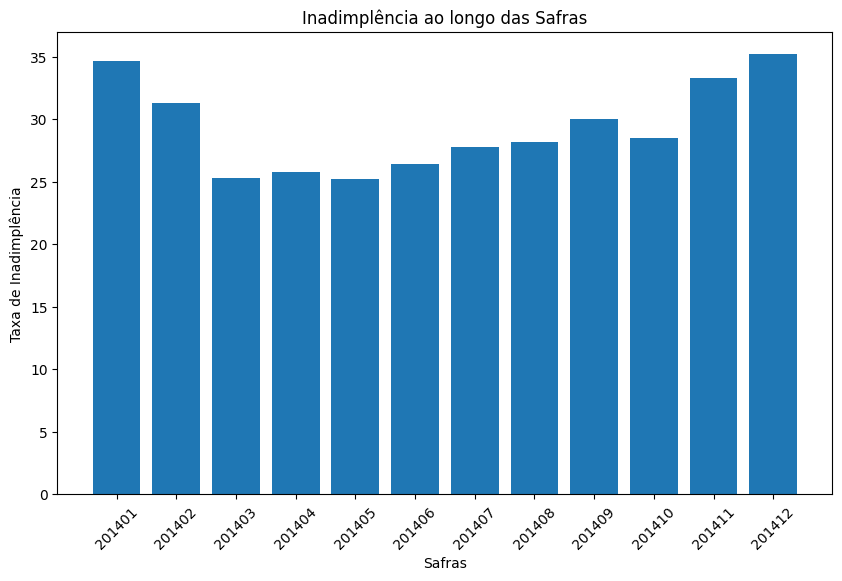

In [ ]:
inadimplencia = base.groupby('safra')['y'].mean().round(3)*100
plt.figure(figsize=(10, 6))
plt.bar([str(safra) for safra in inadimplencia.index.to_list()], inadimplencia.values)
plt.xlabel('Safras')
plt.ylabel('Taxa de Inadimplência')
plt.title('Inadimplência ao longo das Safras')
plt.xticks(rotation=45)
plt.show()

## Análise Variáveis

As variáveis preditoras estão mascaradas. Dessa forma, é um pouco mais complicado construir variáveis a partir de variáveis mascaradas (sem significado aparente).

In [ ]:
print(base.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10738 entries, 0 to 10737
Data columns (total 81 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      10738 non-null  int64  
 1   safra   10738 non-null  int64  
 2   y       10738 non-null  int64  
 3   VAR_1   10322 non-null  float64
 4   VAR_2   10322 non-null  float64
 5   VAR_3   10322 non-null  float64
 6   VAR_4   10322 non-null  float64
 7   VAR_5   6678 non-null   float64
 8   VAR_6   10647 non-null  float64
 9   VAR_7   6106 non-null   float64
 10  VAR_8   5905 non-null   float64
 11  VAR_9   10738 non-null  float64
 12  VAR_10  5173 non-null   float64
 13  VAR_11  5754 non-null   float64
 14  VAR_12  3541 non-null   float64
 15  VAR_13  5520 non-null   float64
 16  VAR_14  5197 non-null   float64
 17  VAR_15  5684 non-null   float64
 18  VAR_16  3631 non-null   float64
 19  VAR_17  6237 non-null   float64
 20  VAR_18  3615 non-null   float64
 21  VAR_19  10677 non-null  float64
 22

In [ ]:
base[variaveis[:20]].describe()

,VAR_1,VAR_2,VAR_3,VAR_4,VAR_5,VAR_6,VAR_7,VAR_8,VAR_9,VAR_10,VAR_11,VAR_12,VAR_13,VAR_14,VAR_15,VAR_16,VAR_17,VAR_18,VAR_19,VAR_20
count,10322.000000,10322.000000,10322.000000,10322.000000,6678.000000,10647.000000,6106.000000,5905.000000,10738.000000,5173.000000,5754.000000,3541.000000,5520.000000,5197.000000,5684.000000,3631.000000,6237.000000,3615.000000,10677.000000,10738.000000
mean,32.999225,0.372312,0.285700,0.576245,92.588026,1489.149338,67.844566,71.023892,1156.501271,459.671564,69.301493,457.369105,89.957121,601.458341,66.221464,88.578353,2382.849782,57.188105,7.822703,10.434811
std,46.367685,1.258638,0.866904,1.213659,78.110019,7336.900964,57.124508,70.204828,663.644517,379.460078,62.657513,390.039932,77.141434,402.504793,54.879727,105.134917,2218.051193,67.247011,16.306541,2.743087
min,0.000000,0.000000,0.000000,0.000000,0.980000,-94.000000,0.010000,0.980000,150.000000,3.000000,0.010000,5.000000,0.990000,5.000000,0.500000,0.000000,26.000000,1.000000,0.000000,3.000000
25%,0.000000,0.000000,0.000000,0.000000,41.242500,446.000000,30.270000,31.410000,650.000000,206.000000,30.545000,198.000000,40.230000,314.000000,30.000000,12.000000,1000.000000,15.000000,0.000000,10.000000
50%,16.000000,0.000000,0.000000,0.000000,70.400000,878.000000,53.150000,54.980000,1000.000000,363.000000,52.745000,354.000000,68.270000,462.000000,50.370000,59.000000,1785.710000,33.000000,0.000000,12.000000
75%,46.000000,0.000000,0.000000,1.000000,117.947500,1991.500000,85.980000,89.980000,1500.000000,594.000000,88.442500,592.000000,114.620000,819.000000,85.002500,127.000000,3000.000000,75.000000,7.000000,12.000000
max,208.000000,17.000000,11.000000,13.000000,814.950000,432895.000000,1035.470000,2891.730000,3000.000000,3414.000000,1652.940000,4284.000000,1059.560000,2114.000000,687.790000,1067.000000,35050.000000,704.000000,119.000000,12.000000


In [ ]:
base[variaveis[20:40]].describe()

,VAR_21,VAR_22,VAR_23,VAR_24,VAR_25,VAR_26,VAR_27,VAR_28,VAR_29,VAR_30,VAR_31,VAR_32,VAR_33,VAR_34,VAR_35,VAR_36,VAR_37,VAR_38,VAR_39,VAR_40
count,3615.000000,10677.000000,5173.000000,6678.000000,10677.000000,5197.000000,4804.000000,10677.000000,4793.000000,10690.000000,4907.000000,10738.000000,10677.000000,5905.000000,5754.000000,3470.000000,4628.000000,6106.000000,5520.000000,10677.000000
mean,1258.266667,10.338578,128.025701,377.008167,2.328276,351.866461,415.331599,2.893603,7.762362,1714.836037,13.556756,115.551042,2.515875,299.513334,288.876769,3.846867,5.947061,278.203875,323.071196,3.252599
std,1395.930104,20.452018,110.997505,309.613316,3.868221,389.028255,269.095390,4.517908,20.942894,1499.953624,25.533440,27.955389,5.715814,288.197555,268.927988,5.780780,23.212748,240.184941,262.970939,4.168673
min,1.000000,0.000000,3.150000,0.980000,0.000000,-4.000000,1.000000,0.000000,-338.000000,150.000000,0.000000,-151.020000,0.000000,0.980000,0.010000,0.000000,-342.000000,0.010000,1.000000,0.000000
25%,349.000000,0.000000,53.600000,171.337500,0.000000,25.000000,186.000000,0.000000,0.000000,800.000000,0.000000,90.630000,0.000000,110.350000,109.492500,0.000000,0.000000,111.962500,147.000000,0.000000
50%,789.000000,0.000000,95.560000,307.000000,0.000000,220.000000,374.000000,0.000000,4.000000,1221.375000,1.000000,133.830000,0.000000,222.280000,219.935000,0.000000,3.000000,218.400000,261.000000,0.000000
75%,1670.000000,11.000000,165.550000,485.812500,4.000000,557.000000,633.000000,6.000000,15.000000,2000.000000,17.000000,133.830000,2.000000,391.020000,378.127500,6.230000,13.000000,369.887500,418.000000,7.000000
max,13042.000000,122.000000,1056.150000,3539.180000,12.000000,1928.000000,1056.000000,12.000000,337.000000,30134.640000,377.000000,133.830000,68.000000,4291.180000,3160.920000,92.800000,245.000000,2932.000000,3008.000000,12.000000


In [ ]:
base[variaveis[40:60]].describe()

,VAR_41,VAR_42,VAR_43,VAR_44,VAR_45,VAR_46,VAR_47,VAR_48,VAR_49,VAR_50,VAR_51,VAR_52,VAR_53,VAR_54,VAR_55,VAR_56,VAR_57,VAR_58,VAR_59,VAR_60
count,3714.000000,4976.000000,3541.000000,10677.000000,5520.000000,5087.000000,3633.000000,4346.000000,3442.000000,4129.000000,5197.000000,5684.000000,8979.000000,9463.000000,3878.000000,3824.000000,10738.000000,6678.000000,6187.000000,10738.000000
mean,4.007178,10.473071,18.603502,4.098998,370.938216,12.243759,76.509705,3.144731,4.004689,200.731363,361.957091,268.978584,2343.622431,1800.752526,198.998563,202.622302,45.963308,329.151243,308.948190,16.260884
std,5.537429,24.160745,16.371873,4.856641,305.023142,29.100602,239.394141,27.301833,5.888585,92.130467,216.081696,235.138390,2378.216375,1639.795179,88.529080,94.026292,12.847511,266.938796,260.588087,335.400492
min,0.000000,-278.000000,1.000000,0.000000,0.990000,-304.000000,0.000000,-337.000000,0.000000,32.320000,2.000000,0.500000,19.380000,11.900000,32.320000,32.320000,18.000000,1.000000,0.000000,-690.750000
25%,0.000000,1.000000,7.000000,0.000000,165.827500,1.000000,0.000000,-1.000000,0.000000,138.310000,228.000000,109.970000,901.090000,800.000000,139.849375,138.592500,36.000000,153.000000,118.580000,-231.740000
50%,1.750000,5.000000,14.000000,1.000000,302.165000,6.000000,0.000000,2.000000,1.315000,183.520000,342.000000,209.945000,1600.000000,1280.420000,184.160000,184.160000,46.000000,263.000000,255.450000,-16.210000
75%,6.447500,17.000000,24.000000,9.000000,477.207500,18.000000,0.000000,11.000000,6.337500,245.640000,419.000000,351.062500,3000.000000,2200.000000,238.785000,251.741667,55.000000,422.000000,426.495000,219.380000
max,42.750000,457.000000,173.000000,12.000000,3049.740000,567.000000,3722.640000,153.000000,64.960000,693.980000,2020.000000,3351.500000,28002.480000,16346.830000,586.780000,693.980000,78.000000,2689.000000,2149.550000,721.630000


In [ ]:
base[variaveis[60:]].describe()

,VAR_61,VAR_62,VAR_63,VAR_64,VAR_65,VAR_66,VAR_67,VAR_68,VAR_69,VAR_70,VAR_71,VAR_72,VAR_73,VAR_74,VAR_75,VAR_76,VAR_77,VAR_78
count,3080.000000,2361.000000,3493.000000,10738.000000,8499.000000,5173.000000,4595.000000,4129.000000,5173.000000,2479.000000,5197.000000,10647.000000,5197.000000,5197.000000,3714.000000,6187.000000,5173.000000,5197.00000
mean,3.417195,1255.239305,194.331102,0.607096,1206.690340,17.630389,-213.140370,0.635263,528.272140,4.889092,0.430825,163.063304,0.423706,0.627093,635.889615,476.559143,64.967429,0.62132
std,5.210202,1062.459013,85.885308,0.488418,1420.268979,15.263864,494.361846,28.130659,432.253087,7.275441,1.154399,306.926216,1.147930,1.543275,623.122985,572.308152,102.159550,1.53912
min,0.000000,418.000000,32.320000,0.000000,0.000000,1.000000,-6582.000000,-337.000000,3.150000,0.000000,0.000000,-104.000000,0.000000,0.000000,32.320000,-876.220000,0.000000,0.00000
25%,0.000000,418.000000,137.420000,0.000000,368.615000,7.000000,-162.000000,-2.000000,238.430000,0.000000,0.000000,9.000000,0.000000,0.000000,310.965000,147.540000,0.000000,0.00000
50%,0.000000,836.000000,178.743333,1.000000,749.400000,14.000000,-51.000000,1.000000,427.490000,2.170000,0.000000,55.000000,0.000000,0.000000,486.990000,318.280000,0.000000,0.00000
75%,5.305000,1672.000000,235.420000,1.000000,1442.765000,23.000000,-15.000000,8.000000,685.510000,7.360000,0.000000,187.500000,0.000000,0.000000,743.380000,601.810000,103.710000,0.00000
max,44.850000,10868.000000,519.670000,1.000000,14004.180000,258.000000,-1.000000,153.000000,4175.260000,65.800000,10.000000,3652.000000,10.000000,16.000000,7862.580000,9426.470000,1173.940000,16.00000


## Variável "VAR_64"
A variável "VAR_64" é uma variável binária e que parece discriminar a variável TARGET.

In [ ]:
base[base['VAR_64']==0].groupby(['VAR_64', 'y'])['id'].count()/len(base[base['VAR_64']==0])

VAR_64  y
0       0    0.786679
        1    0.213321
Name: id, dtype: float64

In [ ]:
base[base['VAR_64']==1].groupby(['VAR_64', 'y'])['id'].count()/len(base[base['VAR_64']==1])

VAR_64  y
1       0    0.65823
        1    0.34177
Name: id, dtype: float64

In [ ]:
base[base['VAR_64']==1].groupby(['safra', 'y'])['id'].count().unstack(fill_value=0).div(base[base['VAR_64']==1].groupby(['safra', 'y'])['id'].count().unstack(fill_value=0).sum(axis=1), axis=0) * 100

y,0,1
safra,,
201401,59.469697,40.530303
201402,63.120567,36.879433
201403,68.679245,31.320755
201404,69.824561,30.175439
201405,70.588235,29.411765
201406,69.804618,30.195382
201407,68.006993,31.993007
201408,66.666667,33.333333
201409,64.473684,35.526316


In [ ]:
base[base['VAR_64']==0].groupby(['safra', 'y'])['id'].count().unstack(fill_value=0).div(base[base['VAR_64']==0].groupby(['safra', 'y'])['id'].count().unstack(fill_value=0).sum(axis=1), axis=0) * 100

y,0,1
safra,,
201401,74.846626,25.153374
201402,78.143713,21.856287
201403,83.965015,16.034985
201404,80.779221,19.220779
201405,81.432361,18.567639
201406,79.941003,20.058997
201407,78.282828,21.717172
201408,80.289855,19.710145
201409,78.550725,21.449275


## Contagem de Nulos

In [ ]:
print(base.isnull().sum())

id           0
safra        0
y            0
VAR_1      416
VAR_2      416
          ... 
VAR_74    5541
VAR_75    7024
VAR_76    4551
VAR_77    5565
VAR_78    5541
Length: 81, dtype: int64


In [ ]:
#Variáveis com maior preenchimento de Nulos
base[variaveis].isnull().sum().sort_values(ascending=False).reset_index(name='Numero de Nulos')

,index,Numero de Nulos
0,VAR_62,8377
1,VAR_70,8259
2,VAR_61,7658
3,VAR_49,7296
4,VAR_36,7268
...,...,...
73,VAR_20,0
74,VAR_32,0
75,VAR_9,0
76,VAR_64,0


In [ ]:
#Variáveis com maior percentual de Nulos
nulos_pct = (base[variaveis].isnull().sum().sort_values(ascending=False)/len(base)).round(3)*100
nulos_pct[nulos_pct > 0].reset_index(name='Porcentagem de Nulos')

,index,Porcentagem de Nulos
0,VAR_62,78.0
1,VAR_70,76.9
2,VAR_61,71.3
3,VAR_49,67.9
4,VAR_36,67.7
...,...,...
67,VAR_40,0.6
68,VAR_28,0.6
69,VAR_33,0.6
70,VAR_44,0.6


Como não sabemos exatamente o que é a variável, não há como justificar o uso de variáveis pouco preenchidas. Variáveis de investimento, por exemplo, possuem baixo preenchimento, no entanto tem alto poder de discriminação.

In [ ]:
# Lista com variáveis qtd de nulos > 50%
vars_nulas = nulos_pct[nulos_pct>50].reset_index(name='Nulos')['index'].to_list()
len(vars_nulas)

38

## Distribuição das variáveis ao longo das Safras

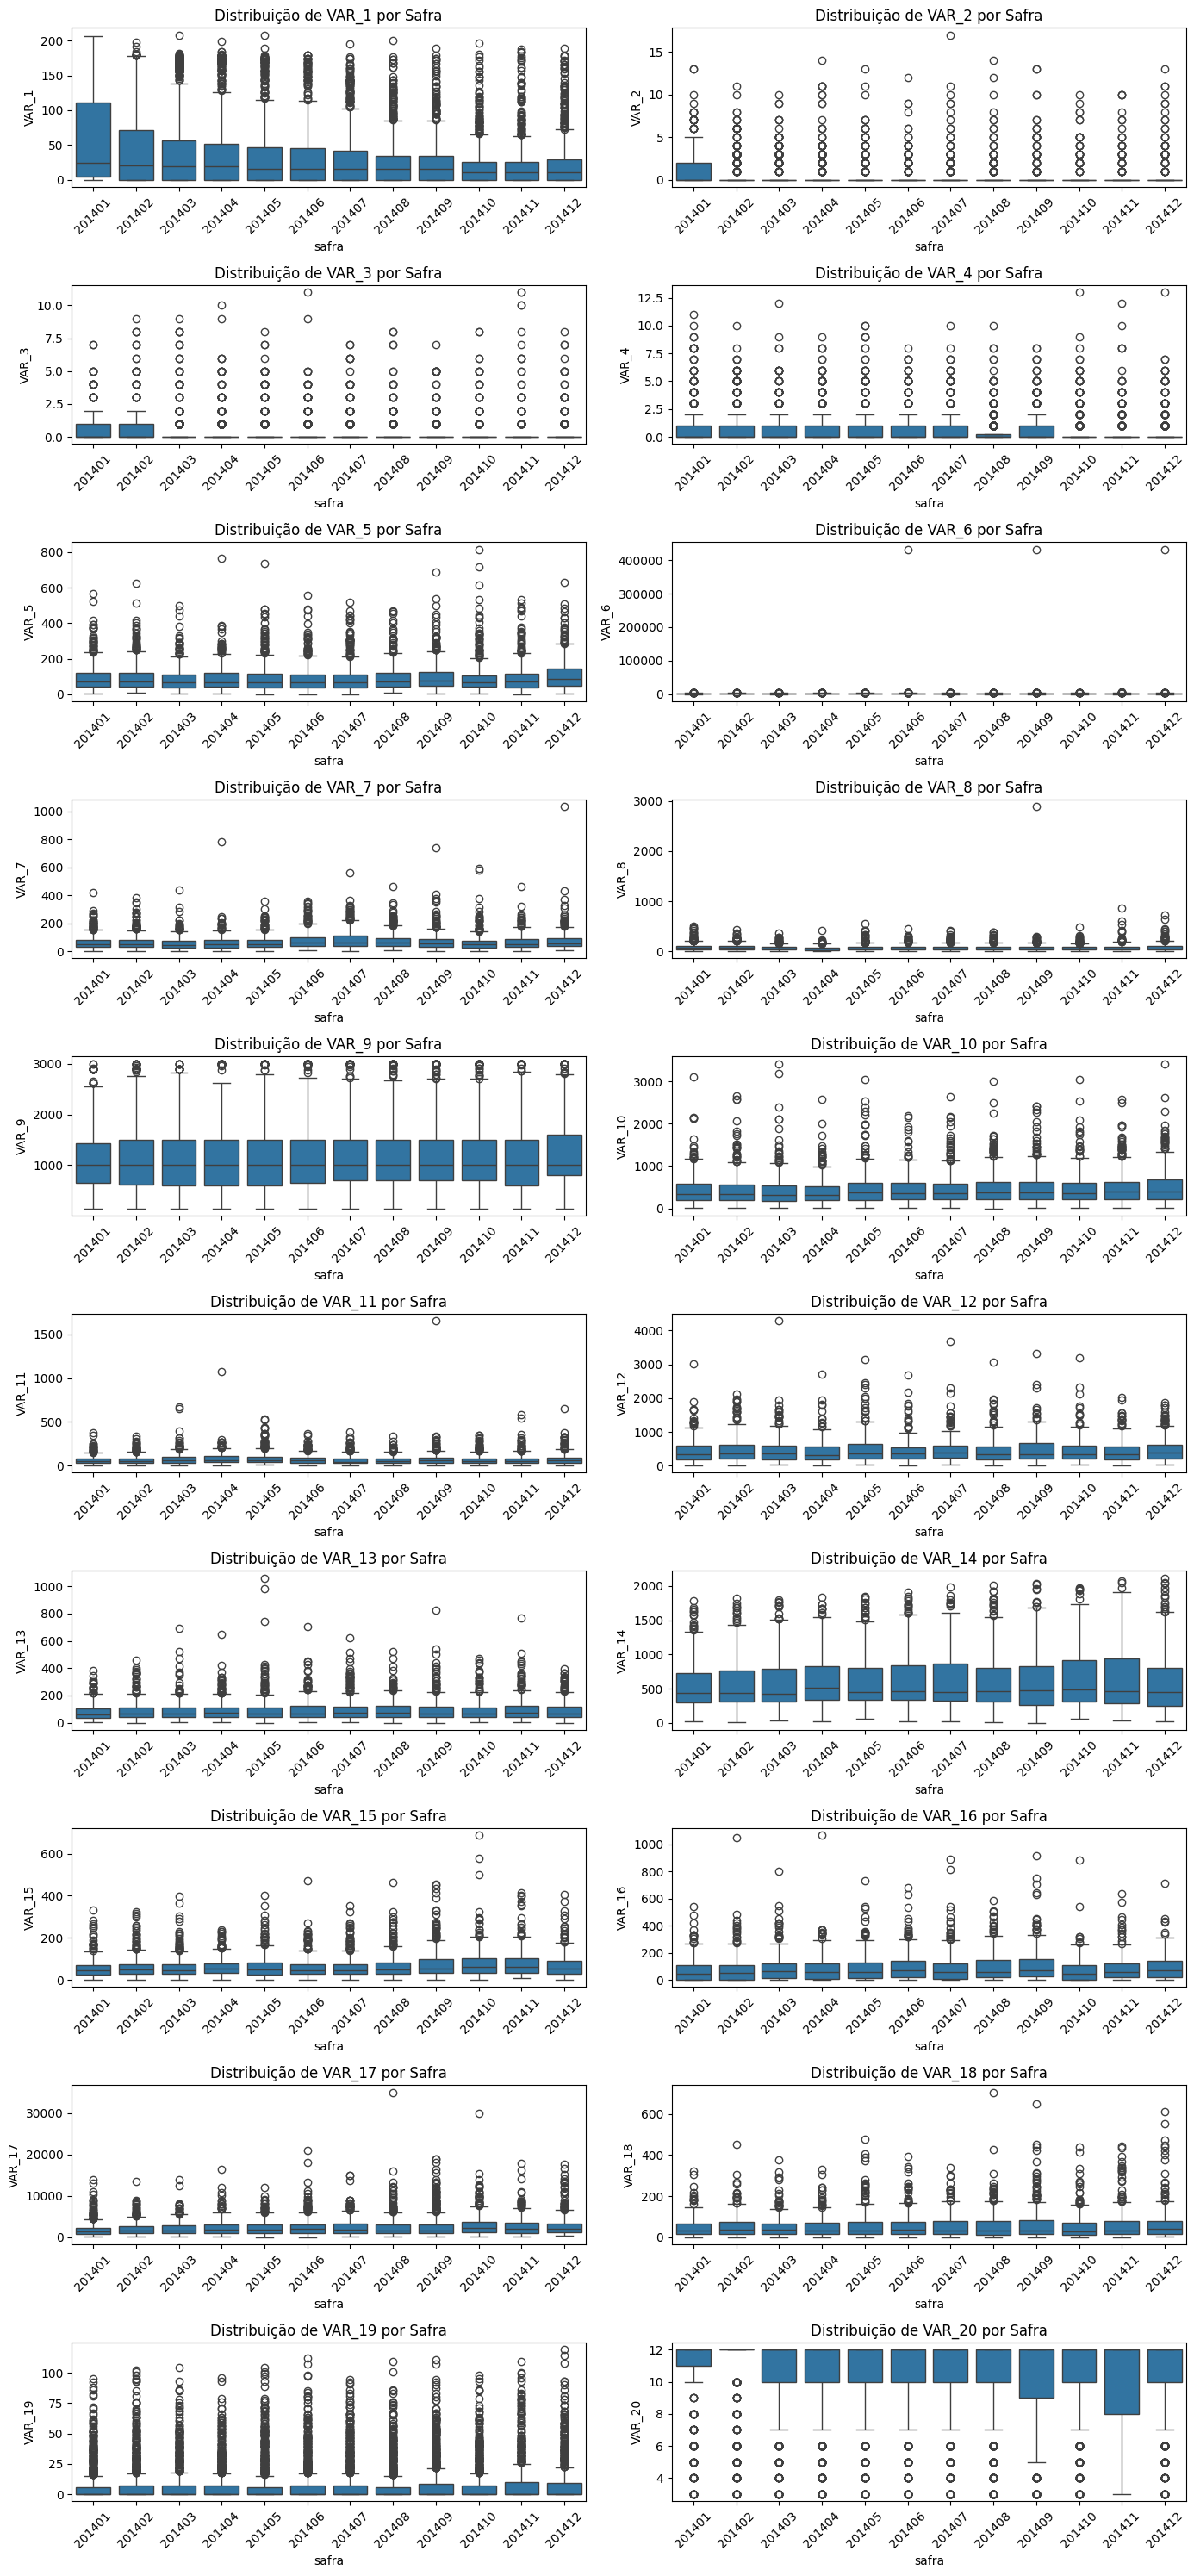

In [ ]:
fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(14, 30))
axes = axes.flatten()

for i, var in enumerate(variaveis[:20]):
    sns.boxplot(data=base, x="safra", y=var, ax=axes[i])
    axes[i].set_title(f"Distribuição de {var} por Safra")
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

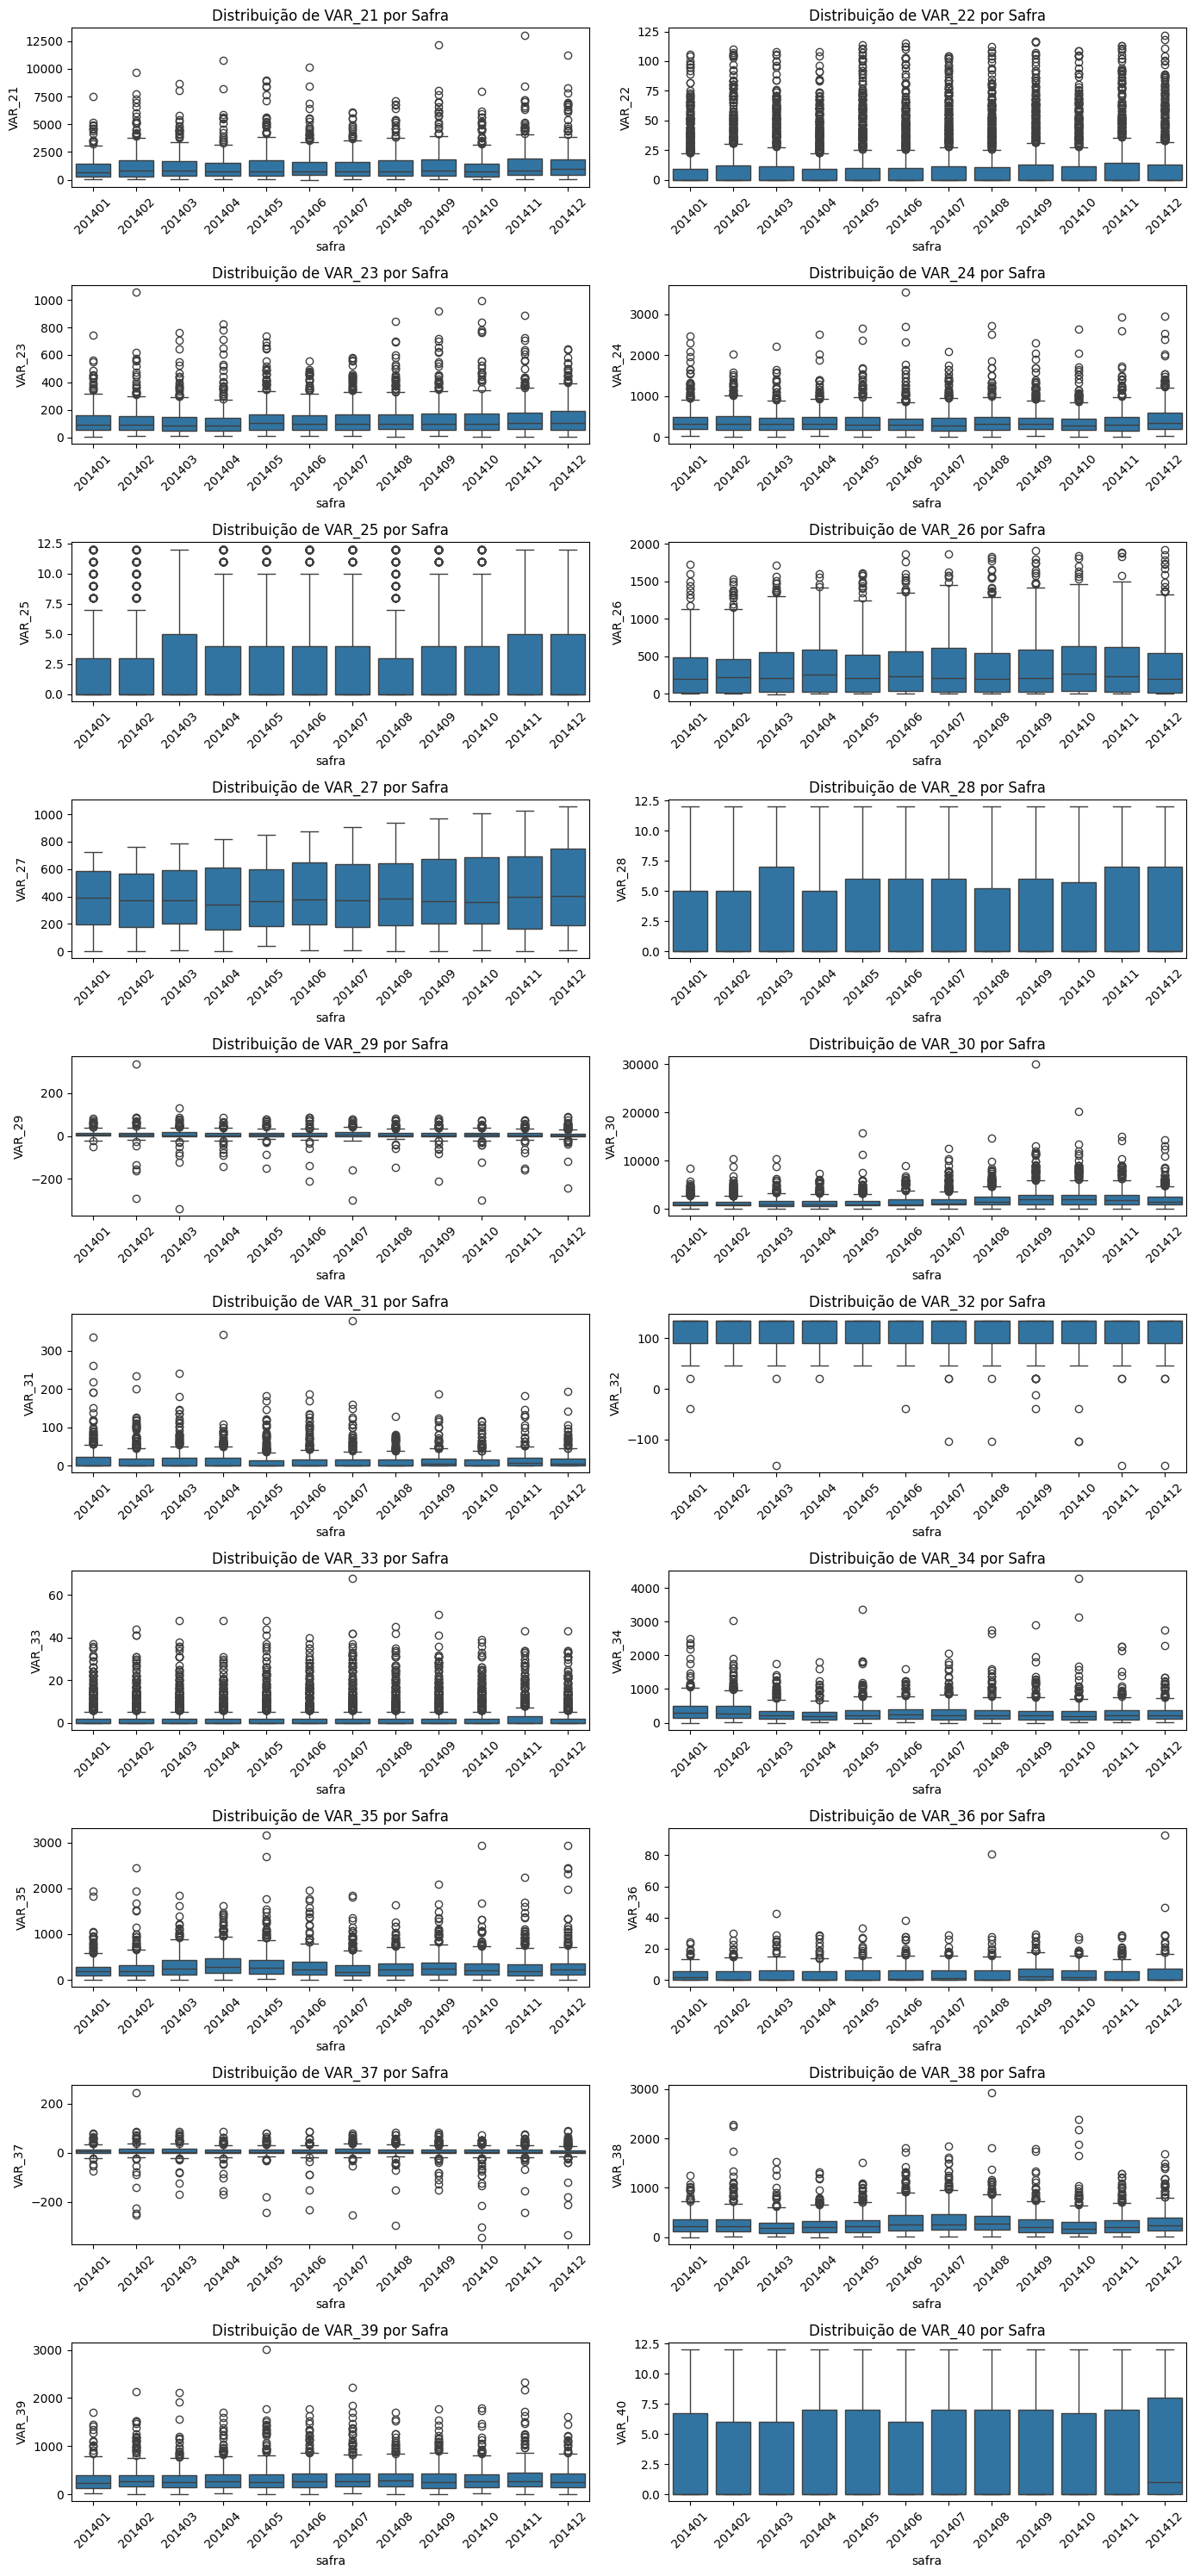

In [ ]:
fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(14, 30))
axes = axes.flatten()

for i, var in enumerate(variaveis[20:40]):
    sns.boxplot(data=base, x="safra", y=var, ax=axes[i])
    axes[i].set_title(f"Distribuição de {var} por Safra")
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

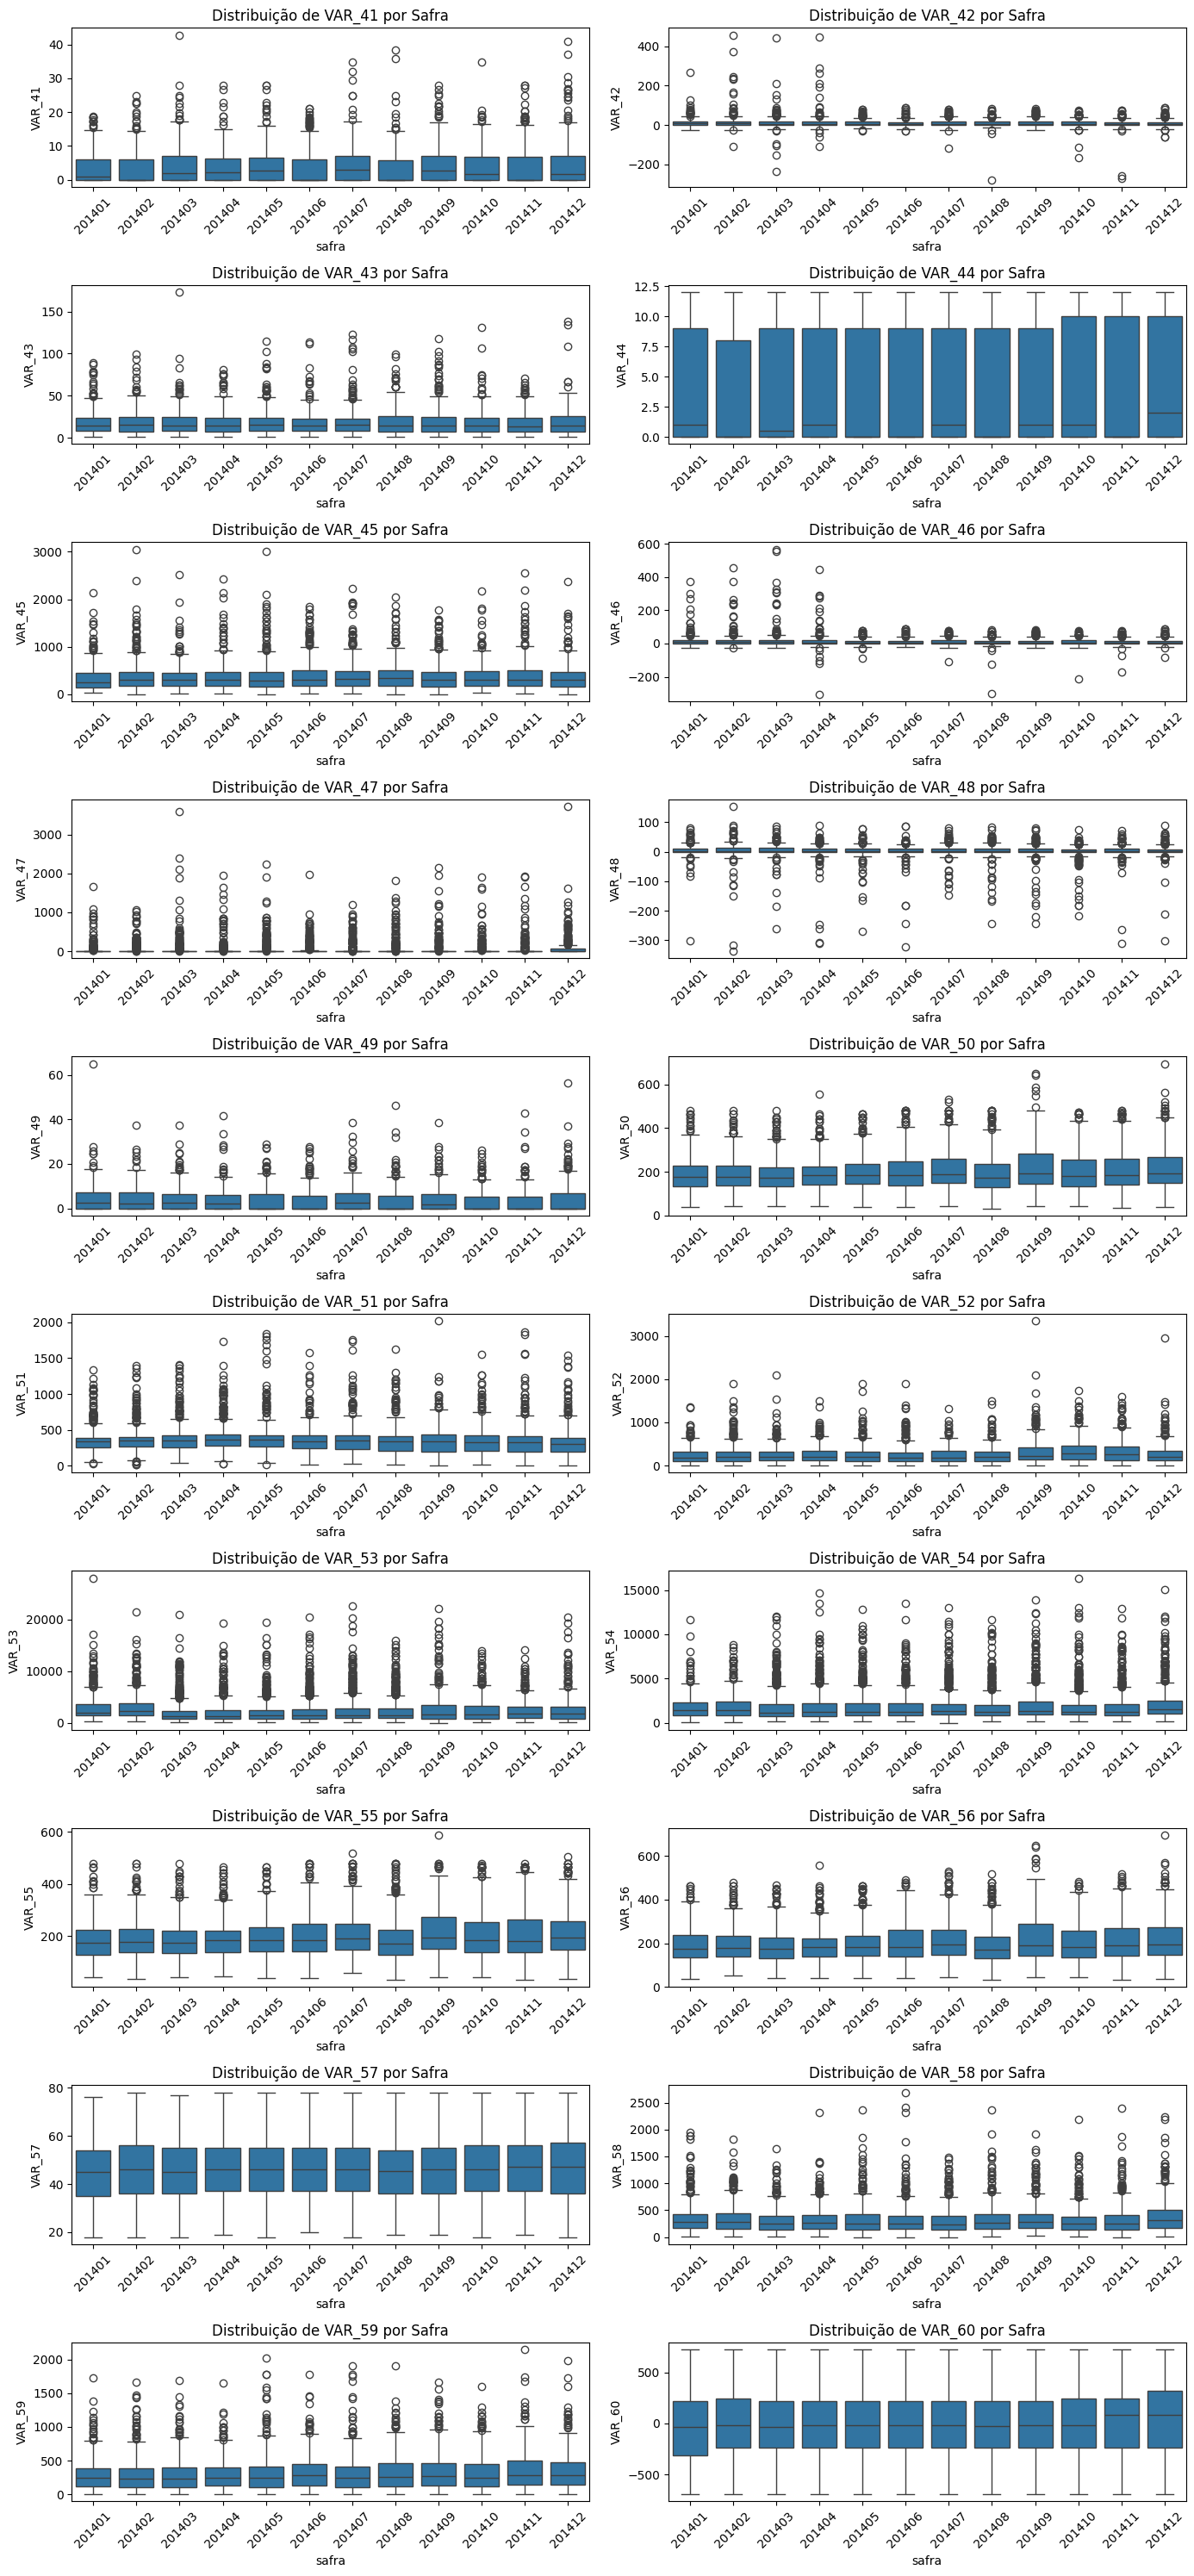

In [ ]:
fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(14, 30))
axes = axes.flatten()

for i, var in enumerate(variaveis[40:60]):
    sns.boxplot(data=base, x="safra", y=var, ax=axes[i])
    axes[i].set_title(f"Distribuição de {var} por Safra")
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

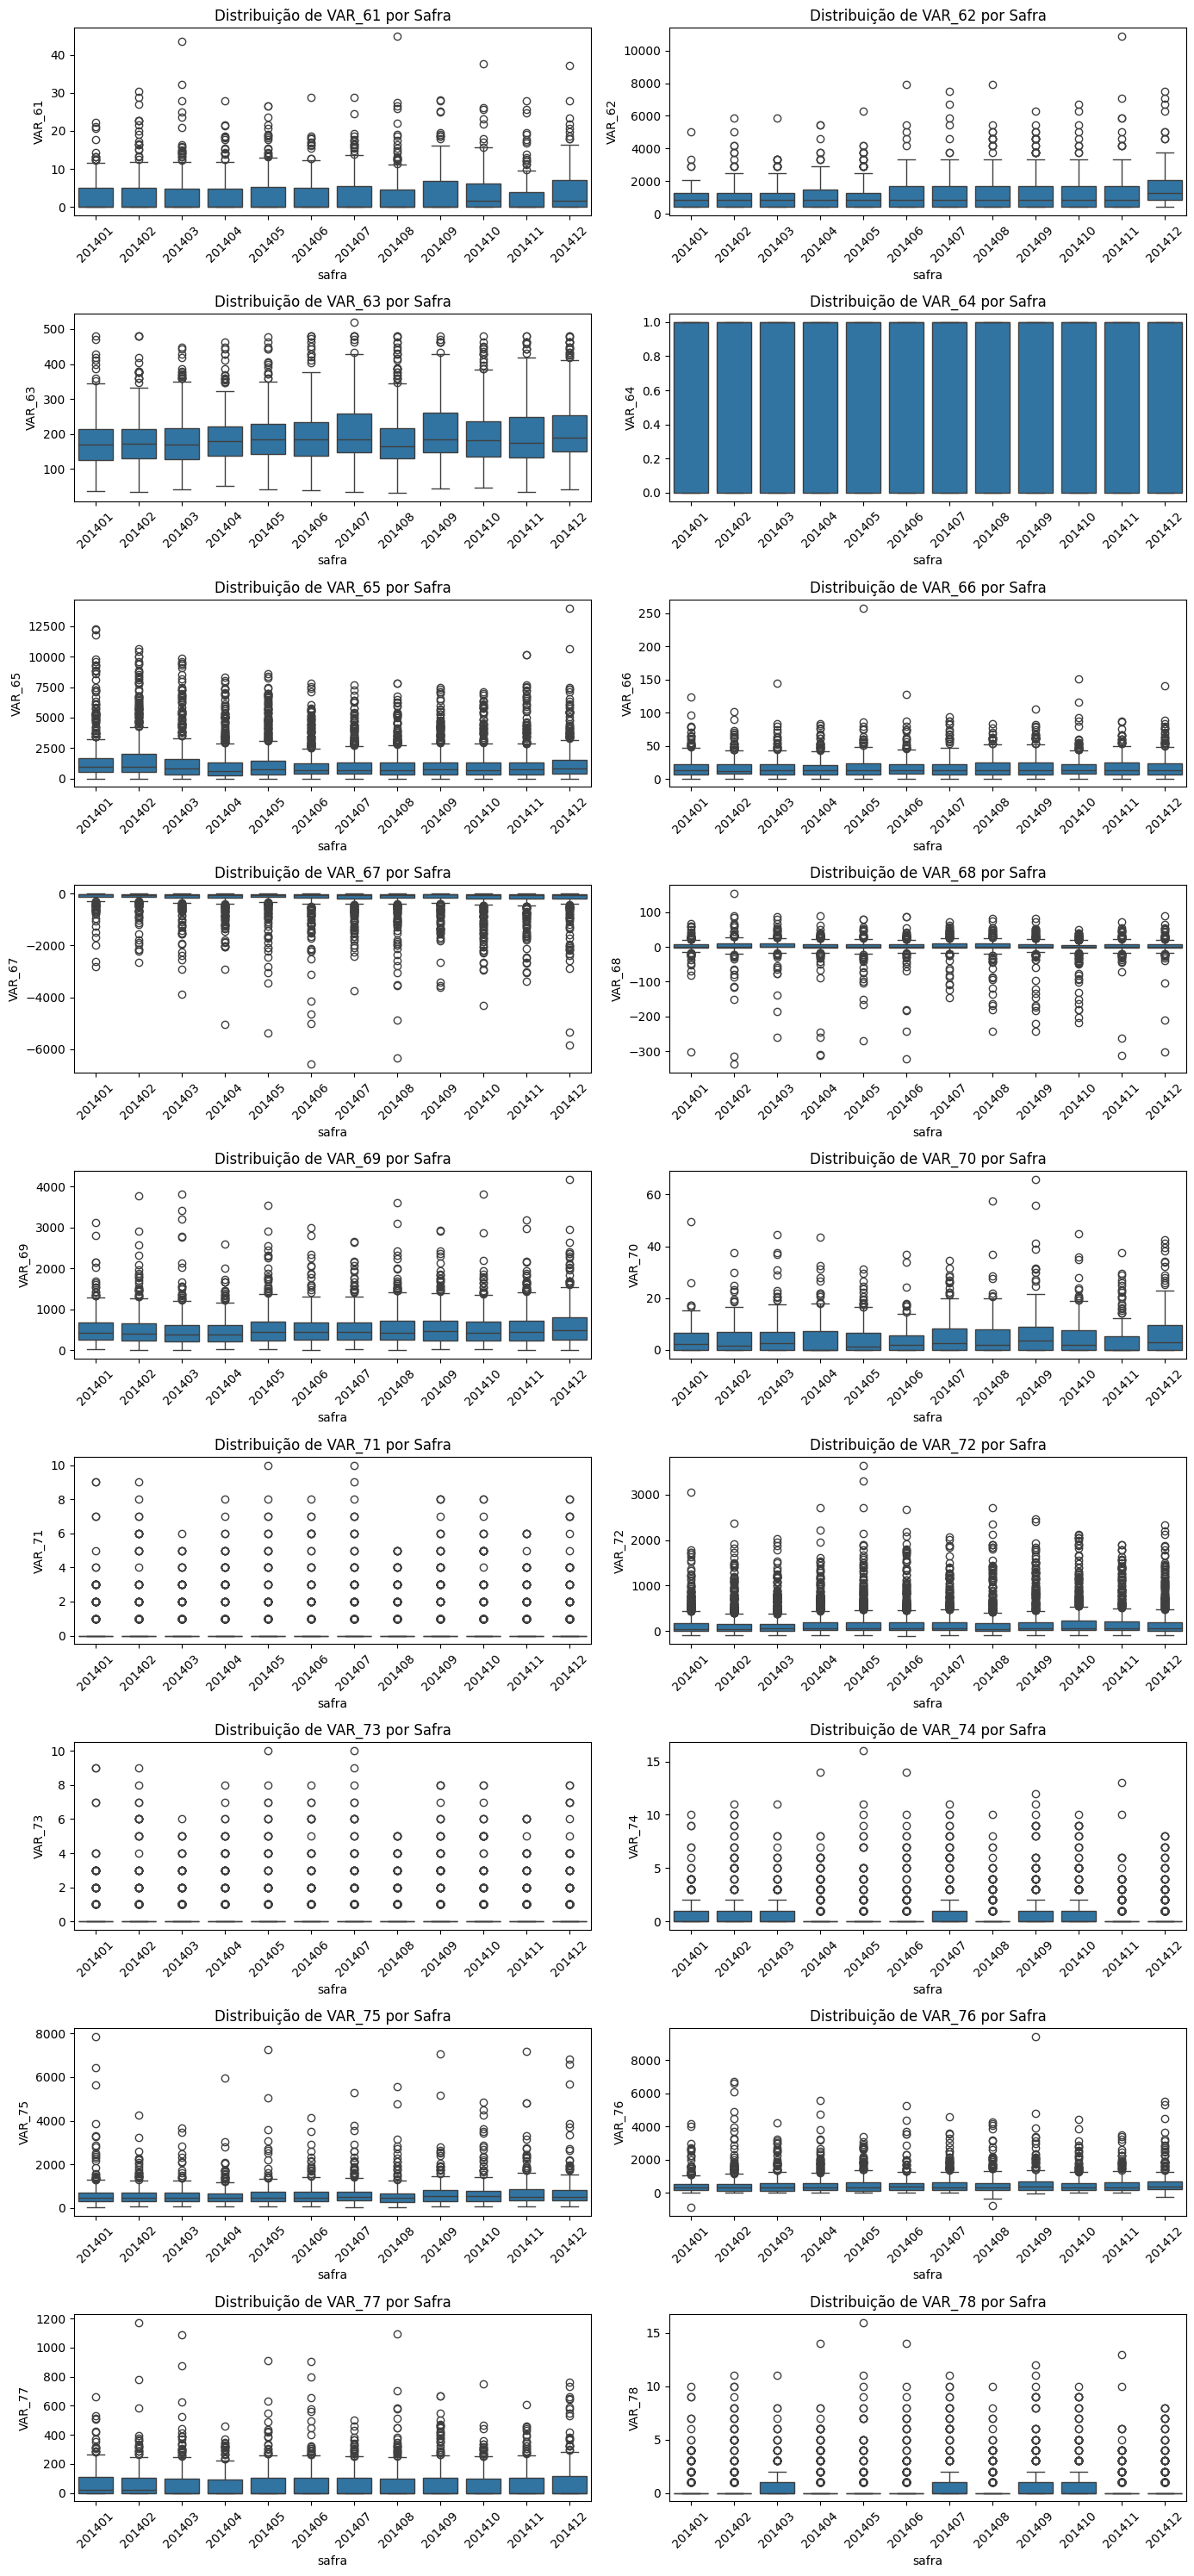

In [ ]:
fig, axes = plt.subplots(nrows=9, ncols=2, figsize=(14, 30))
axes = axes.flatten()

for i, var in enumerate(variaveis[60:]):
    sns.boxplot(data=base, x="safra", y=var, ax=axes[i])
    axes[i].set_title(f"Distribuição de {var} por Safra")
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## PSI ao Longo das Safras

In [ ]:
psi_teste = {var: calculate_psi(base_treino[var].dropna(), base_teste[var].dropna()) for var in variaveis}
psi_val = {var: calculate_psi(base_treino[var].dropna(), base_validacao[var].dropna()) for var in variaveis}

In [ ]:
#Variáveis que possuem alto PSI no Conjunto de Teste (>0)
psi_df = pd.DataFrame({'Teste': psi_teste, 'Validacao': psi_val})
psi_df.sort_values('Teste', ascending=False)[psi_df['Teste'] > 0]

<ipython-input-96-d35c6a148a1e>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  psi_df.sort_values('Teste', ascending=False)[psi_df['Teste'] > 0]


,Teste,Validacao
VAR_2,8.51,2.65
VAR_41,5.35,0.61
VAR_71,5.32,3.15
VAR_73,4.09,2.89
VAR_3,3.84,1.87
VAR_61,3.47,1.30
VAR_49,2.94,0.20
VAR_4,2.30,2.28
VAR_78,2.06,1.21
VAR_74,2.01,1.24


In [ ]:
#Variáveis que possuem alto PSI no Conjunto de Validação (>0)
psi_df = pd.DataFrame({'Teste': psi_teste, 'Validacao': psi_val})
psi_df.sort_values('Validacao', ascending=False)[psi_df['Validacao'] > 0]

<ipython-input-97-ee66b2bb687a>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  psi_df.sort_values('Validacao', ascending=False)[psi_df['Validacao'] > 0]


,Teste,Validacao
VAR_20,1.66,3.83
VAR_71,5.32,3.15
VAR_73,4.09,2.89
VAR_2,8.51,2.65
VAR_4,2.30,2.28
VAR_3,3.84,1.87
VAR_64,0.15,1.85
VAR_44,0.86,1.30
VAR_61,3.47,1.30
VAR_74,2.01,1.24


In [ ]:
psi_df = pd.DataFrame({'Teste': psi_teste, 'Validacao': psi_val})
psi_df['Diferenca'] = abs(psi_df['Teste'] - psi_df['Validacao']).round(2)
psi_df.sort_values('Diferenca', ascending=False)[psi_df['Diferenca'] > 0]

<ipython-input-98-8fbc229df016>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  psi_df.sort_values('Diferenca', ascending=False)[psi_df['Diferenca'] > 0]


,Teste,Validacao,Diferenca
VAR_2,8.51,2.65,5.86
VAR_41,5.35,0.61,4.74
VAR_49,2.94,0.20,2.74
VAR_71,5.32,3.15,2.17
VAR_61,3.47,1.30,2.17
VAR_20,1.66,3.83,2.17
VAR_3,3.84,1.87,1.97
VAR_64,0.15,1.85,1.70
VAR_73,4.09,2.89,1.20
VAR_78,2.06,1.21,0.85


## Correlação entre Variáveis No Treino, Teste e Validação

In [ ]:
corr_train = X_train.corr()
corr_table_train = corr_train.unstack().sort_values(ascending=False).drop_duplicates()
df_corr_train = corr_table_train[(abs(corr_table_train) > 0.7)&(corr_table_train != 1)].reset_index(name='Correlação Treino')
df_corr_train

,level_0,level_1,Correlação Treino
0,VAR_74,VAR_78,0.998761
1,VAR_73,VAR_71,0.997553
2,VAR_57,VAR_60,0.990969
3,VAR_56,VAR_50,0.978673
4,VAR_19,VAR_22,0.975606
5,VAR_10,VAR_69,0.975125
6,VAR_24,VAR_58,0.974086
7,VAR_28,VAR_25,0.973283
8,VAR_39,VAR_45,0.972463
9,VAR_50,VAR_55,0.968374


In [ ]:
corr_test = X_test.corr()
corr_table_test = corr_test.unstack().sort_values(ascending=False).drop_duplicates()
df_corr_test = corr_table_test[(abs(corr_table_test) > 0.7)&(corr_table_test != 1)].reset_index(name='Correlação Teste')
df_corr_test

,level_0,level_1,Correlação Teste
0,VAR_78,VAR_74,0.999608
1,VAR_71,VAR_73,0.998632
2,VAR_57,VAR_60,0.991391
3,VAR_50,VAR_56,0.990536
4,VAR_19,VAR_22,0.979989
5,VAR_69,VAR_10,0.979550
6,VAR_50,VAR_55,0.977136
7,VAR_58,VAR_24,0.975879
8,VAR_39,VAR_45,0.973083
9,VAR_25,VAR_28,0.973017


In [ ]:
corr_val = X_val.corr()
corr_table_val = corr_val.unstack().sort_values(ascending=False).drop_duplicates()
df_corr_val = corr_table_val[(abs(corr_table_val) > 0.7)&(corr_table_val != 1)].reset_index(name='Correlação Validação')
df_corr_val

,level_0,level_1,Correlação Validação
0,VAR_74,VAR_78,0.999665
1,VAR_73,VAR_71,0.997943
2,VAR_57,VAR_60,0.991739
3,VAR_56,VAR_50,0.982834
4,VAR_10,VAR_69,0.979546
5,VAR_19,VAR_22,0.979047
6,VAR_24,VAR_58,0.977411
7,VAR_48,VAR_68,0.975288
8,VAR_45,VAR_39,0.975167
9,VAR_55,VAR_50,0.975066


In [ ]:
df_corr = pd.merge(df_corr_train, df_corr_test, on=['level_0', 'level_1'], how='outer')
df_corr = pd.merge(df_corr, df_corr_val, on=['level_0', 'level_1'], how='outer')
df_corr

,level_0,level_1,Correlação Treino,Correlação Teste,Correlação Validação
0,VAR_1,VAR_2,0.711717,NaN,NaN
1,VAR_10,VAR_23,0.884913,0.831960,NaN
2,VAR_10,VAR_66,NaN,0.753996,NaN
3,VAR_10,VAR_69,0.975125,NaN,0.979546
4,VAR_11,VAR_35,0.711103,0.763560,NaN
...,...,...,...,...,...
96,VAR_74,VAR_78,0.998761,NaN,0.999665
97,VAR_78,VAR_71,0.866564,NaN,0.885080
98,VAR_78,VAR_73,0.862156,NaN,0.881638
99,VAR_78,VAR_74,NaN,0.999608,NaN


## PSI por safra

In [ ]:
safras = sorted(base[base['safra']>=test_init]["safra"].unique())
safras

[201410, 201411, 201412]

In [ ]:
psi_results = {}

for feature in variaveis:
    psi_results[feature] = {}
    baseline = X_train[feature].dropna().values
    for safra in safras:
        period_df = base[base["safra"] == safra]
        psi_value = calculate_psi(baseline, period_df[feature].dropna().values, bins=10)
        psi_results[feature][safra] = psi_value

In [ ]:
psi_threshold = 0.1
vars_psi = []
for feature, psi_dict in psi_results.items():
    psi_values = list(psi_dict.values())
    if max(psi_values) > psi_threshold:
        vars_psi.append(feature)
vars_psi

['VAR_1',
 'VAR_2',
 'VAR_3',
 'VAR_4',
 'VAR_5',
 'VAR_15',
 'VAR_16',
 'VAR_18',
 'VAR_19',
 'VAR_20',
 'VAR_22',
 'VAR_23',
 'VAR_25',
 'VAR_27',
 'VAR_28',
 'VAR_29',
 'VAR_31',
 'VAR_33',
 'VAR_36',
 'VAR_37',
 'VAR_40',
 'VAR_41',
 'VAR_42',
 'VAR_43',
 'VAR_44',
 'VAR_46',
 'VAR_48',
 'VAR_49',
 'VAR_50',
 'VAR_56',
 'VAR_57',
 'VAR_61',
 'VAR_63',
 'VAR_64',
 'VAR_68',
 'VAR_70',
 'VAR_71',
 'VAR_73',
 'VAR_74',
 'VAR_78']

In [ ]:
len(vars_psi)

40

## Retirar Variáveis de alto PSI e Nulas do Conjunto de Variáveis

In [ ]:
vars_keep = [k for k in variaveis if k not in (vars_psi+vars_nulas)]
vars_keep

['VAR_6',
 'VAR_7',
 'VAR_8',
 'VAR_9',
 'VAR_11',
 'VAR_13',
 'VAR_17',
 'VAR_24',
 'VAR_30',
 'VAR_32',
 'VAR_34',
 'VAR_35',
 'VAR_38',
 'VAR_39',
 'VAR_45',
 'VAR_52',
 'VAR_53',
 'VAR_54',
 'VAR_58',
 'VAR_59',
 'VAR_60',
 'VAR_65',
 'VAR_72',
 'VAR_76']

In [ ]:
base_treino = base[base['safra'].between(train_init, train_end)].fillna(-999999999)
base_teste = base[base['safra'].between(test_init, test_end)].fillna(-999999999)
base_validacao = base[base['safra'].between(val_init, val_end)].fillna(-999999999)


X_train, y_train = base_treino[vars_keep], base_treino[target]
X_test, y_test = base_teste[vars_keep], base_teste[target]
X_val, y_val = base_validacao[vars_keep], base_validacao[target]

In [ ]:
len(vars_keep)

24

## Informação Mútua das Variáveis

In [ ]:
mi_scores = mutual_info_classif(X_train, y_train, random_state=13)

mi_df = pd.DataFrame({"Variável": X_train.columns, "MI_Score": mi_scores})

mi_df = mi_df.sort_values(by="MI_Score", ascending=False)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
mi_df[mi_df['MI_Score']>0.01]

,Variável,MI_Score
6,VAR_17,0.025338
21,VAR_65,0.016738
0,VAR_6,0.016633
3,VAR_9,0.015577
20,VAR_60,0.015523
9,VAR_32,0.013131
17,VAR_54,0.013090
8,VAR_30,0.012337
16,VAR_53,0.011831
23,VAR_76,0.010143


In [ ]:
mi_df[mi_df['MI_Score']>0.01]['Variável'].to_list()

['VAR_17',
 'VAR_65',
 'VAR_6',
 'VAR_9',
 'VAR_60',
 'VAR_32',
 'VAR_54',
 'VAR_30',
 'VAR_53',
 'VAR_76']

# Feature Selection - Correlação e Informação Mútua
1. Identificação de Colunas Altamente Correlacionadas:
Calcule a matriz de correlação e identifique pares de variáveis que possuam uma correlação acima de um certo limiar (0.7). Essa etapa permite detectar redundância, ou seja, quando duas ou mais variáveis carregam informações similares.


2. Seleção Baseada em Critério de Relevância (Informação Mútua):
Para cada grupo de variáveis correlacionadas, calculamos a informação mútua de cada variável em relação à variável target. Mantemos em cada grupo, apenas aquela que apresenta o maior valor de informação mútua. Reduz a multicolinearidade e melhora na robustez do modelo, pois a variável selecionada é a que mais reduz a incerteza em relação à target.

In [ ]:
vars_mi = features_corr_mi(X_train, y_train, threshold=0.7)
vars_mi

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['VAR_6',
 'VAR_7',
 'VAR_8',
 'VAR_9',
 'VAR_17',
 'VAR_24',
 'VAR_30',
 'VAR_32',
 'VAR_35',
 'VAR_52',
 'VAR_53',
 'VAR_54',
 'VAR_60',
 'VAR_65']

In [ ]:
len(vars_mi)

14

## Feature Selection - Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators=50,
                            random_state=13)
rf.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(n_estimators=50, random_state=13)

In [ ]:
importances = rf.feature_importances_
feature_importances = pd.DataFrame({'Variável': X_train.columns, 'Importância': (importances*100).round(2)})
feature_importances = feature_importances.sort_values(by='Importância', ascending=False)
feature_importances

,Variável,Importância
0,VAR_6,7.53
3,VAR_9,6.36
6,VAR_17,6.29
16,VAR_53,6.02
22,VAR_72,6.00
21,VAR_65,5.79
17,VAR_54,5.46
8,VAR_30,5.32
20,VAR_60,5.19
12,VAR_38,3.88


In [ ]:
vars_rf = feature_importances[feature_importances['Importância']>= 1]['Variável'].to_list()
vars_rf

['VAR_6',
 'VAR_9',
 'VAR_17',
 'VAR_53',
 'VAR_72',
 'VAR_65',
 'VAR_54',
 'VAR_30',
 'VAR_60',
 'VAR_38',
 'VAR_7',
 'VAR_52',
 'VAR_58',
 'VAR_35',
 'VAR_34',
 'VAR_24',
 'VAR_76',
 'VAR_11',
 'VAR_59',
 'VAR_8',
 'VAR_13',
 'VAR_45',
 'VAR_39',
 'VAR_32']

In [ ]:
len(vars_rf)

24

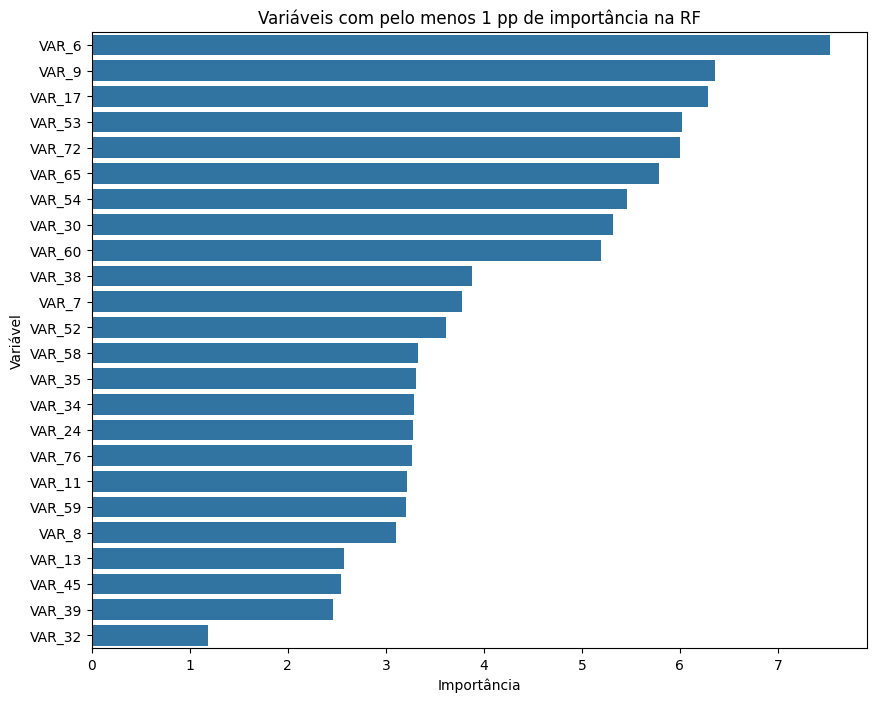

In [ ]:
plt.figure(figsize=(10, 8))
sns.barplot(x='Importância', y='Variável', data=feature_importances[feature_importances['Importância']>= 1])
plt.title('Variáveis com pelo menos 1 pp de importância na RF')
plt.show()

## RFE

In [ ]:
estimador = LogisticRegression(solver='liblinear', random_state=13, max_iter=1000)
rfe = RFE(estimator=estimador, n_features_to_select=39)
rfe.fit(X_train, y_train.values.reshape(-1))

/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=39 > n_features=24. There will be no feature selection and all features will be kept.
  warnings.warn(


RFE(estimator=LogisticRegression(max_iter=1000, random_state=13,
                                 solver='liblinear'),
    n_features_to_select=39)

In [ ]:
vars_rfe = X_train.columns[rfe.support_].tolist()
print("Features selecionadas via RFE:", len(vars_rfe))
vars_rfe

Features selecionadas via RFE: 24


['VAR_6',
 'VAR_7',
 'VAR_8',
 'VAR_9',
 'VAR_11',
 'VAR_13',
 'VAR_17',
 'VAR_24',
 'VAR_30',
 'VAR_32',
 'VAR_34',
 'VAR_35',
 'VAR_38',
 'VAR_39',
 'VAR_45',
 'VAR_52',
 'VAR_53',
 'VAR_54',
 'VAR_58',
 'VAR_59',
 'VAR_60',
 'VAR_65',
 'VAR_72',
 'VAR_76']

## Variáveis dentro de mais de um conjunto

As variáveis selecionadas utilizando a Random Forest e utilizando RFE (com a Regressão Logística) apresentaram o mesmo conjunto de variáveis.

In [ ]:
[k for k in vars_rfe if k not in vars_rf]

[]

In [ ]:
[k for k in vars_rf if k not in vars_rfe]

[]